In [12]:
import numpy as np
import tensorflow as tf
import tensorboard_jupyter as tb
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn import datasets

ops.reset_default_graph()
sess = tf.Session()

#2.6の回帰の例
batch_size = 25

# 平均1、標準偏差0.1の正規分布を作成
x_vals = np.random.normal(1, 0.1, 100)
with tf.name_scope('x'):
    x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
# 10を100個
y_vals = np.repeat(10., 100)

with tf.name_scope('y'):
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# データをトレーニングセットとテストセットに8:2で分割
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace= False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]

y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# 予測結果の変数は最初はランダムで初期化
with tf.name_scope('A'):
    A = tf.Variable(tf.random_normal(shape=[1,1]))

# 計算グラフに乗算を追加する。
with tf.name_scope('model'):
    my_output = tf.matmul(x_data, A)
# L2損失関数(最小二乗法)
# 平均１のx_dataとAの乗算と10との差分のため、Aは10に収束するはず
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.square(my_output - y_target))

# 変数最適化方法
my_opt = tf.train.GradientDescentOptimizer(learning_rate=0.02)
# L2損失を最小化するようにする
train_step = my_opt.minimize(loss)

# 変数初期化
init = tf.global_variables_initializer()
sess.run(init)

# トレーニング
for i in range(100):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    # 1行25列から25行1列へ変換
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%25 == 0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(loss, feed_dict={x_data:rand_x, y_target: rand_y})))

mse_test = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_test]), y_target: np.transpose([y_vals_test])})
mse_train = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_train]), y_target: np.transpose([y_vals_train])})
print('MSE on test: ' + str(np.round(mse_test, 2)))
print('MSE on train: ' + str(np.round(mse_train, 2)))
        
tf.summary.FileWriter('./log/', sess.graph)
tb.show_graph(tf.get_default_graph().as_graph_def())

Step #25 A = [[ 6.20395088]]
Loss = 15.9325
Step #50 A = [[ 8.57587433]]
Loss = 1.88605
Step #75 A = [[ 9.45653248]]
Loss = 1.25016
Step #100 A = [[ 9.77085876]]
Loss = 0.994985
MSE on test: 1.27
MSE on train: 0.86


In [21]:
## 分類の例 ##
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

# 平均-1と3のデータを50こずつ
x_vals = np.concatenate((np.random.normal(-1, 1, 50),
                        np.random.normal(2, 1, 50)))

with tf.name_scope('x_data') as scope:
    x_data = tf.placeholder(shape=[1, None], dtype=tf.float32)    
    
y_vals = np.concatenate([np.repeat(0., 50), np.repeat(1., 50)])
with tf.name_scope('y_target') as scope:
    y_target = tf.placeholder(shape=[1, None], dtype=tf.float32)

# データをトレーニングセットとテストセットに8:2で分割
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace= False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]

y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]
    
# 予測値は本来と離れた10で初期化
with tf.name_scope('A') as scope:
    A = tf.Variable(tf.random_normal(mean=10, shape=[1]))
    
# モデルは平均移動計算(sigmoid(x + A)だがsigmoidは損失関数が行う)
with tf.name_scope('Model') as scope:
    my_output = tf.add(x_data, A)

# シグモイド誤差エントロピー損失関数
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output, labels=y_target)
# 最適化関数
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

init = tf.global_variables_initializer()
sess.run(init)

for i in range(1800):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = [x_vals_train[rand_index]]
    rand_y = [y_vals_train[rand_index]]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%200==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(xentropy, feed_dict={x_data: rand_x, y_target: rand_y})))


with tf.name_scope('prediction') as scope:
    y_prediction = tf.squeeze(tf.round(tf.nn.sigmoid(tf.add(x_data, A))))
    correct_prediction = tf.equal(y_prediction, y_target)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_value_test = sess.run(accuracy, feed_dict={x_data: [x_vals_test], y_target: [y_vals_test]})
acc_value_train = sess.run(accuracy, feed_dict={x_data: [x_vals_train], y_target: [y_vals_train]})
print('Accuracy on train set: ' + str(acc_value_train))
print('Accuracy on test set: ' + str(acc_value_test))
        
tf.summary.FileWriter('./log/', sess.graph)
tb.show_graph(tf.get_default_graph().as_graph_def())

Step #200 A = [-0.69047976]
Loss = [[ 0.16616148  0.65559411  0.89609718  0.05554588  0.08533639  0.46616307
   0.07652663  0.10405916  0.02700546  0.11825523  0.95115638  0.03222379
   0.08100253  0.4198207   0.11449566  0.11449566  0.10343304  0.08100253
   0.10612128  0.42004126  0.4198207   0.19641592  0.07536426  0.07536426
   0.10612128]]
Step #400 A = [-0.56424481]
Loss = [[ 0.24569601  0.1195773   0.06775134  0.52938318  0.1195773   0.12276029
   0.08553281  0.05267632  0.29887959  0.43578029  0.15737741  0.4063105
   0.09197678  0.05463177  0.21694562  0.12276029  0.46515566  0.07558858
   0.1195773   0.10910847  0.05534232  0.38110635  0.33341065  0.06278943
   0.06079619]]
Step #600 A = [-0.6002931]
Loss = [[ 0.06295894  0.05455804  0.11334316  0.08955632  0.26493016  1.11108971
   0.13227196  0.11636318  0.43350312  0.07015296  0.05731658  0.05455804
   0.05584619  0.41891679  0.10110906  0.11266427  0.15220828  0.43464652
   0.17198761  0.46298206  0.10512213  1.11108971  

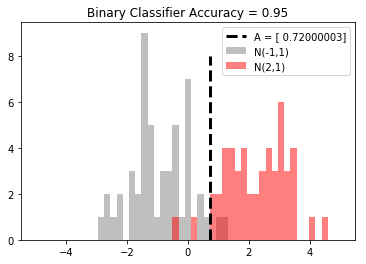

In [24]:
# 可視化
A_result = -sess.run(A)
bins = np.linspace(-5, 5, 50)
plt.hist(x_vals[0:50], bins, alpha = 0.5, label='N(-1,1)', color='gray')
plt.hist(x_vals[50:100], bins[0:50], alpha = 0.5, label='N(2,1)', color='red')
plt.plot((A_result, A_result), (0,8), 'k--', linewidth=3, label='A = ' + str(np.round(A_result, 2)))
plt.legend(loc='upper right')
plt.title('Binary Classifier Accuracy = ' + str(np.round(acc_value_test, 2)))
plt.show()